# SWPLA PDDA 2020 Synthetic Sonic Log Generation Contest

**Author:** Ben Dowdell

**Date:** March XX, 2020

**Purpose:** To minimize RMSE in predicting Sonic logs (compressional & shear) from a suite of standard well logs

**Outline**

1. Initial Imports
1. Read Data
1. Inspect & Clean Data
1. EDA
1. Prep data for model build
1. Model testing
1. Summary of findings

### Data Decription
#### Files
#### train.csv
All the values equals to -999 are marked as missing values.
- CAL - Caliper, unit in Inch,  
- CNC - Neutron, unit in dec 
- GR - Gamma Ray, unit in API
- HRD - Deep Resisitivity, unit in Ohm per meter,
- HRM - Medium Resistivity, unit in Ohm per meter,
- PE - Photo-electric Factor, unit in Barn,
- ZDEN - Density, unit in Gram per cubit meter, 
- DTC - Compressional Travel-time, unit in nanosecond per foot,
- DTS - Shear Travel-time, unit in nanosecond per foot,


#### test.csv
The test data has all features that you used in the train dataset, except the two sonic curves DTC and DTS.

####  sample_submission.csv
A valid sample submission.
<p><font style="">
</font></p>

## 1. Initial Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## 2. Read in Data

In [2]:
df_w1 = pd.read_csv('../data/train.csv')

In [3]:
df_w1.head()

,CAL,CNC,GR,HRD,HRM,PE,ZDEN,DTC,DTS
0,-999.0,-999.0,41.4699,-999.0,-999.0,-999.0,-999.0,128.0737,319.0654
1,-999.0,-999.0,42.5053,-999.0,-999.0,-999.0,-999.0,127.8347,318.7825
2,-999.0,-999.0,43.1548,-999.0,-999.0,-999.0,-999.0,127.2307,317.3323
3,-999.0,-999.0,43.2410,-999.0,-999.0,-999.0,-999.0,126.2917,313.6486
4,-999.0,-999.0,40.3218,-999.0,-999.0,-999.0,-999.0,125.3985,307.8903


## 3. Inspect & Clean the Data

In [4]:
df_w1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30143 entries, 0 to 30142
Data columns (total 9 columns):
CAL     30143 non-null float64
CNC     30143 non-null float64
GR      30143 non-null float64
HRD     30143 non-null float64
HRM     30143 non-null float64
PE      30143 non-null float64
ZDEN    30143 non-null float64
DTC     30143 non-null float64
DTS     30143 non-null float64
dtypes: float64(9)
memory usage: 2.1 MB


All data are type float64

In [5]:
df_w1.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
CAL,30143.0,-8.394576,129.970219,-999.0,8.05835,8.6250,9.04885,21.0642
CNC,30143.0,-23.692615,157.142679,-999.0,0.12280,0.1936,0.33715,3490.1582
GR,30143.0,38.959845,108.504554,-999.0,17.24875,36.8218,58.34615,1470.2534
HRD,30143.0,3.977690,365.112753,-999.0,0.71770,1.6230,3.15830,10000.0000
HRM,30143.0,1.547299,456.908969,-999.0,0.71205,1.6281,3.28060,60467.7617
PE,30143.0,-17.446739,149.083136,-999.0,0.05310,4.9415,7.85665,28.1064
ZDEN,30143.0,-20.229982,148.809506,-999.0,2.22670,2.4322,2.55135,3.2597
DTC,30143.0,-54.891703,372.858812,-999.0,66.30435,78.3551,107.02250,155.9803
DTS,30143.0,-9.737567,440.314119,-999.0,118.53435,137.6893,182.97315,487.4384


Samples with value of -999.0 need to be replaced with NaN

In [6]:
df_w1.replace(to_replace=-999.0, value=np.nan, inplace=True)

In [7]:
df_w1.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
CAL,29633.0,8.654281,1.749145,5.9304,8.135600,8.62500,9.063000,21.0642
CNC,29408.0,0.683437,30.689679,-0.1028,0.127100,0.19850,0.343100,3490.1582
GR,29889.0,47.780541,51.377519,-0.1460,18.026100,37.08220,58.532800,1470.2534
HRD,29758.0,16.953912,349.067878,0.0541,0.740450,1.66275,3.180350,10000.0000
HRM,29758.0,14.492077,445.361622,0.0616,0.734700,1.66515,3.308900,60467.7617
PE,29464.0,5.173227,4.781088,-0.0232,0.054200,5.04250,7.949700,28.1064
ZDEN,29462.0,2.393818,0.196276,-1.9238,2.234800,2.43960,2.553000,3.2597
DTC,26089.0,91.814381,24.337910,49.9705,71.357000,85.23760,112.112600,155.9803
DTS,25278.0,180.655730,81.141960,80.5804,129.446625,144.59305,191.475125,487.4384


There are some suspicious values here that we will explore in the next step.

1. CNC should range from 0.0 to 1.0
1. GR should not have values less than 0.0
1. PE should not have values less than 0.0
1. ZDEN should not have values less than 0.0

## 4. Exploratory Data Analysis (EDA)

Before making any edits to values, plot the data for visual QC inspection

In [8]:
def plot_well_curves(data):
    """
    Plots well log curves from an input data frame containing the data
    
    Parameters:
    data (pandas.DataFrame) : Input data frame containing the well log curves, one per column
    
    curve_names (list) : A list containing the column name of each well log curve in the input data frame
    
    Returns:
    matplotlib.figure.Figure
    """
    # get the column names as a list
    curve_names = data.columns.tolist()
    
    # create the figure
    fig, axes = plt.subplots(nrows=1, ncols=len(curve_names), sharey=True, figsize=(20,10))
    fig.suptitle('Training Well Data', fontsize=20)
    for ax, curve in zip(axes, curve_names):
        if curve in ['HRD', 'HRM']:
            ax.semilogx(data[curve], data.index, color='k')
        else:
            ax.plot(data[curve], data.index, color='k')
        if curve == 'CNC':
            ax.set_xlim(0.0, 1.0)
        if curve in ['DTC', 'DTS']:
            ax.set_title(curve, fontdict={'color':'r'})
            ax.invert_xaxis()
        else:
            ax.set_title(curve)
        ax.xaxis.tick_top()
        ax.invert_yaxis()
    fig.text(0.04, 0.5, 'Depth', va='center', rotation='vertical', fontdict={'fontsize':20})
    return fig

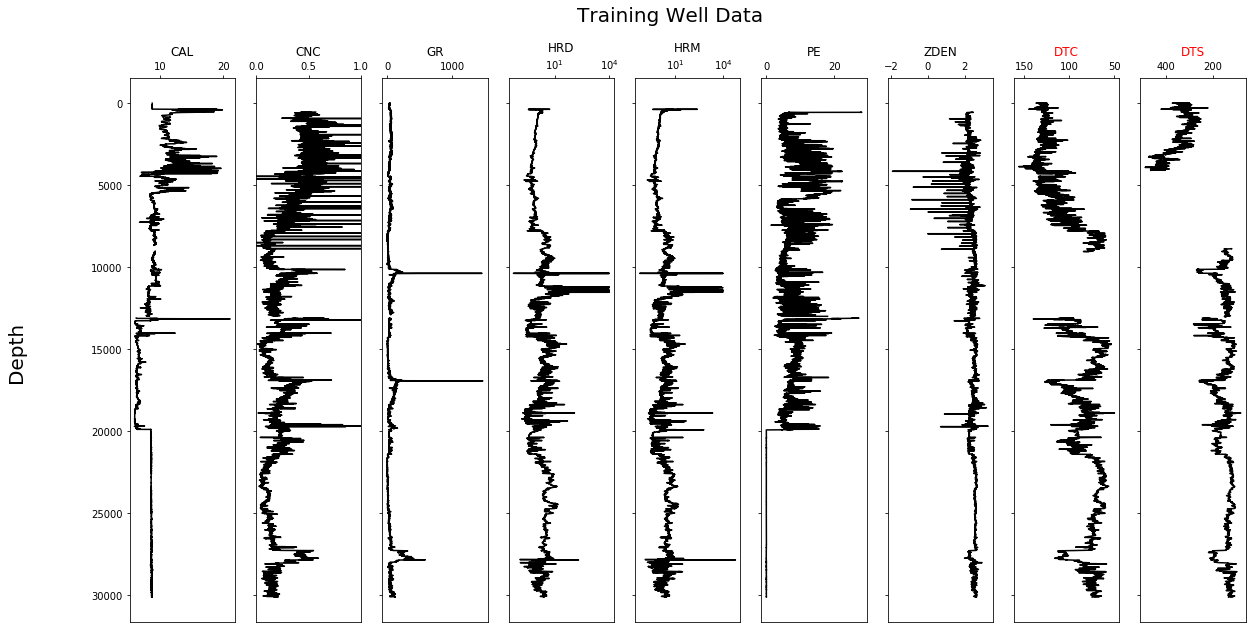

In [9]:
well_plot_fig = plot_well_curves(df_w1)
plt.show()

In [10]:
df_w1.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
CAL,29633.0,8.654281,1.749145,5.9304,8.135600,8.62500,9.063000,21.0642
CNC,29408.0,0.683437,30.689679,-0.1028,0.127100,0.19850,0.343100,3490.1582
GR,29889.0,47.780541,51.377519,-0.1460,18.026100,37.08220,58.532800,1470.2534
HRD,29758.0,16.953912,349.067878,0.0541,0.740450,1.66275,3.180350,10000.0000
HRM,29758.0,14.492077,445.361622,0.0616,0.734700,1.66515,3.308900,60467.7617
PE,29464.0,5.173227,4.781088,-0.0232,0.054200,5.04250,7.949700,28.1064
ZDEN,29462.0,2.393818,0.196276,-1.9238,2.234800,2.43960,2.553000,3.2597
DTC,26089.0,91.814381,24.337910,49.9705,71.357000,85.23760,112.112600,155.9803
DTS,25278.0,180.655730,81.141960,80.5804,129.446625,144.59305,191.475125,487.4384


Limit CNC to range between 0.0 and 1.0

In [11]:
df_w1.loc[df_w1['CNC'] < 0.0, ['CNC']] = np.nan
df_w1.loc[df_w1['CNC'] > 1.0, ['CNC']] = np.nan

Limit GR to range between 0.0 and 250.0

In [12]:
df_w1.loc[df_w1['GR'] < 0.0, ['GR']] = np.nan
df_w1.loc[df_w1['GR'] > 250.0, ['GR']] = np.nan

Limit PE to have values no less than 0.0

In [13]:
df_w1.loc[df_w1['PE'] < 0.0, ['PE']] = np.nan

Limit ZDEN to have values no less than 0.0

In [14]:
df_w1.loc[df_w1['ZDEN'] < 0.0, ['ZDEN']] = np.nan

In [15]:
df_w1.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
CAL,29633.0,8.654281,1.749145,5.9304,8.135600,8.62500,9.063000,21.0642
CNC,29308.0,0.247144,0.155301,0.0041,0.126800,0.19800,0.340900,0.9997
GR,29513.0,44.140058,36.486081,0.0000,17.682600,36.71940,57.633200,249.9048
HRD,29758.0,16.953912,349.067878,0.0541,0.740450,1.66275,3.180350,10000.0000
HRM,29758.0,14.492077,445.361622,0.0616,0.734700,1.66515,3.308900,60467.7617
PE,29455.0,5.174812,4.780959,0.0000,0.054200,5.04380,7.950150,28.1064
ZDEN,29454.0,2.394661,0.189292,0.0035,2.234900,2.43970,2.553100,3.2597
DTC,26089.0,91.814381,24.337910,49.9705,71.357000,85.23760,112.112600,155.9803
DTS,25278.0,180.655730,81.141960,80.5804,129.446625,144.59305,191.475125,487.4384


These value ranges are substantially more acceptable.  Re-plot the data and visually inspect

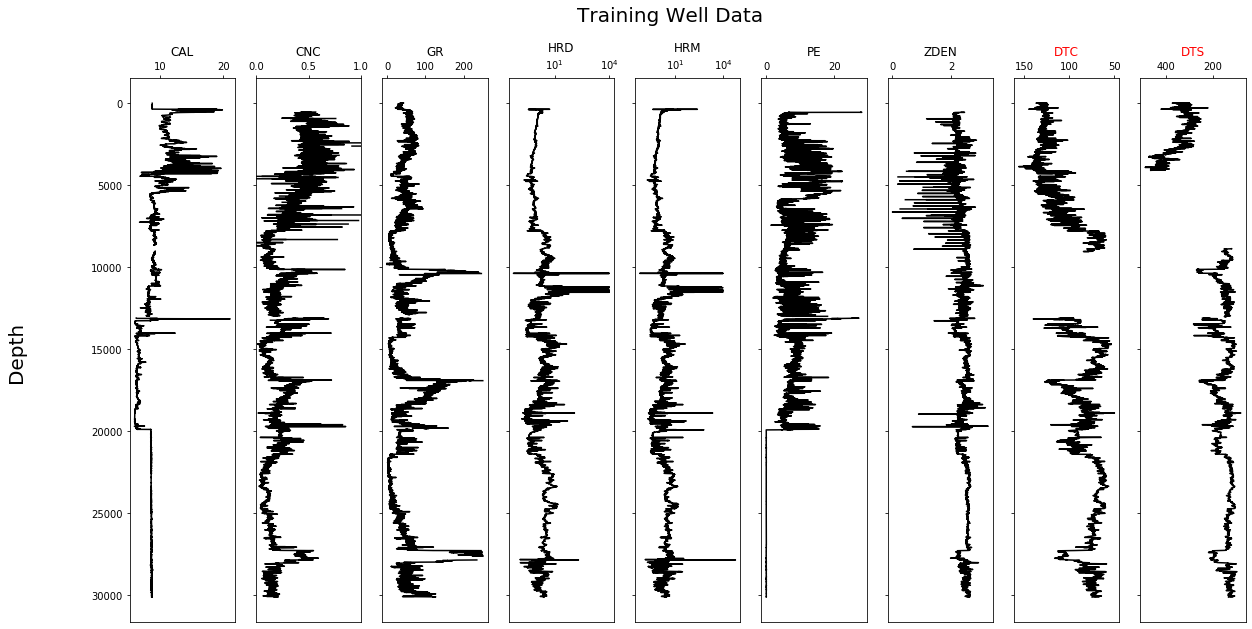

In [16]:
well_plot_fig = plot_well_curves(df_w1)
plt.show()

Overall, this appears to be better.  The PE final 10,000' values look suspect, though.

Let's attempt filtering out the spikes remaining in the data.

In [17]:
def filter_curves(data, window, n_std):
    """
    Takes a data frame containing well log curves and filters outliers based on n-standard deviations
    from a median filtered version of the data.
    
    Parameters:
    data (pandas.DataFrame) : The input data frame containing data to be filtered.  Each column is a well log curve.
    
    window (int) : The size of the window to use in creating a median filtered curve (recommend 33)
    
    n_std (int) : The number of +/- standard deviations to use in considering outliers (recommend 2)
    
    Returns:
    df_clean (pandas.DataFrame) : The filtered well curves
    df_outliers (pandas.DataFrame) : The outlier data points removed by the filtering operation
    """
    # create a copy of the original data
    df_copy = data.copy()
    
    # create a data frame containing median-filtered version of the data
    df_medfilter = pd.DataFrame()
    for col in df_copy.columns.tolist():
        df_medfilter[col] = df_copy[col].rolling(window, center=True).median()
        
    # create a data frame containing standard deviation of the data
    df_stddev = pd.DataFrame()
    for col in df_copy.columns.tolist():
        df_stddev[col] = df_copy[col].rolling(window, center=True).std()
        
    # create a data frame containing the cleaned version of the data using standard deviation from the median filtered data
    # and create a data frame containing the removed outliers
    df_clean = pd.DataFrame()
    df_outliers = pd.DataFrame()
    for col in df_copy.columns.tolist():
        upper = df_medfilter[col] + df_stddev[col]*n_std
        lower = df_medfilter[col] - df_stddev[col]*n_std
        df_clean[col] = df_copy[col].where((df_copy[col] <= upper) & (df_copy[col] >= lower))
        #df_clean[col] = df_clean[col].interpolate(limit_area='inside')
        df_outliers[col] = df_copy[col].where(df_clean[col] != df_copy[col])
    
    return df_clean, df_outliers

In [18]:
def compare_well_curves(data_raw, data_cleaned, data_outliers):
    """
    Plots well log curves from an input data frame containing the data
    
    Parameters:
    data (pandas.DataFrame) : Input data frame containing the well log curves, one per column
    
    curve_names (list) : A list containing the column name of each well log curve in the input data frame
    
    Returns:
    matplotlib.figure.Figure
    """
    # get the column names as a list, assumes col names are the same for each input data frame
    curve_names = data_raw.columns.tolist()
    
    # build the figure
    fig, axes = plt.subplots(nrows=1, ncols=len(curve_names), sharey=True, figsize=(20,10))
    fig.suptitle('Training Well Data', fontsize=20)
    for ax, curve in zip(axes, curve_names):
        if curve in ['HRD', 'HRM']:
            ax.semilogx(data_raw[curve], data_raw.index, color='k', lw=3)
            ax.semilogx(data_cleaned[curve], data_cleaned.index, color='r', lw=1)
            ax.semilogx(data_outliers[curve], data_outliers.index, lw=0, marker='.', mfc='y', mec='k', alpha=0.2)
        else:
            ax.plot(data_raw[curve], data_raw.index, color='k', lw=3)
            ax.plot(data_cleaned[curve], data_cleaned.index, color='r', lw=1)
            ax.plot(data_outliers[curve], data_outliers.index, lw=0, marker='o', mfc='y', mec='k', alpha=0.2)
        if curve == 'CNC':
            ax.set_xlim(0.0, 1.0)
        if curve in ['DTC', 'DTS']:
            ax.set_title(curve, fontdict={'color':'r'})
            ax.invert_xaxis()
        else:
            ax.set_title(curve)
        ax.xaxis.tick_top()
        ax.invert_yaxis()
    fig.text(0.04, 0.5, 'Depth (ft.)', va='center', rotation='vertical', fontdict={'fontsize':20})
    return fig

In [19]:
df_clean, df_outliers = filter_curves(df_w1, 33, 1)

In [20]:
df_w1.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
CAL,29633.0,8.654281,1.749145,5.9304,8.135600,8.62500,9.063000,21.0642
CNC,29308.0,0.247144,0.155301,0.0041,0.126800,0.19800,0.340900,0.9997
GR,29513.0,44.140058,36.486081,0.0000,17.682600,36.71940,57.633200,249.9048
HRD,29758.0,16.953912,349.067878,0.0541,0.740450,1.66275,3.180350,10000.0000
HRM,29758.0,14.492077,445.361622,0.0616,0.734700,1.66515,3.308900,60467.7617
PE,29455.0,5.174812,4.780959,0.0000,0.054200,5.04380,7.950150,28.1064
ZDEN,29454.0,2.394661,0.189292,0.0035,2.234900,2.43970,2.553100,3.2597
DTC,26089.0,91.814381,24.337910,49.9705,71.357000,85.23760,112.112600,155.9803
DTS,25278.0,180.655730,81.141960,80.5804,129.446625,144.59305,191.475125,487.4384


In [21]:
df_clean.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
CAL,24172.0,8.679015,1.692838,5.9304,8.178325,8.62500,9.104475,19.8462
CNC,21287.0,0.236605,0.145115,0.0183,0.125100,0.19100,0.321000,0.6953
GR,22000.0,43.030624,33.750652,1.7081,17.748475,36.45150,56.962425,237.4727
HRD,24469.0,4.175916,53.828973,0.0541,0.717300,1.63300,3.146800,2738.6460
HRM,23734.0,3.852493,42.733338,0.0616,0.701025,1.58615,3.229300,3003.3633
PE,21516.0,5.143477,4.599355,0.0189,0.054400,5.04510,7.696325,25.0025
ZDEN,22469.0,2.392358,0.170914,1.8184,2.231600,2.43170,2.549700,2.9315
DTC,20005.0,91.383918,24.142788,53.6041,71.230300,84.58150,110.599500,146.9254
DTS,19518.0,178.127551,78.954206,96.9005,129.027550,143.75325,189.038825,470.6586


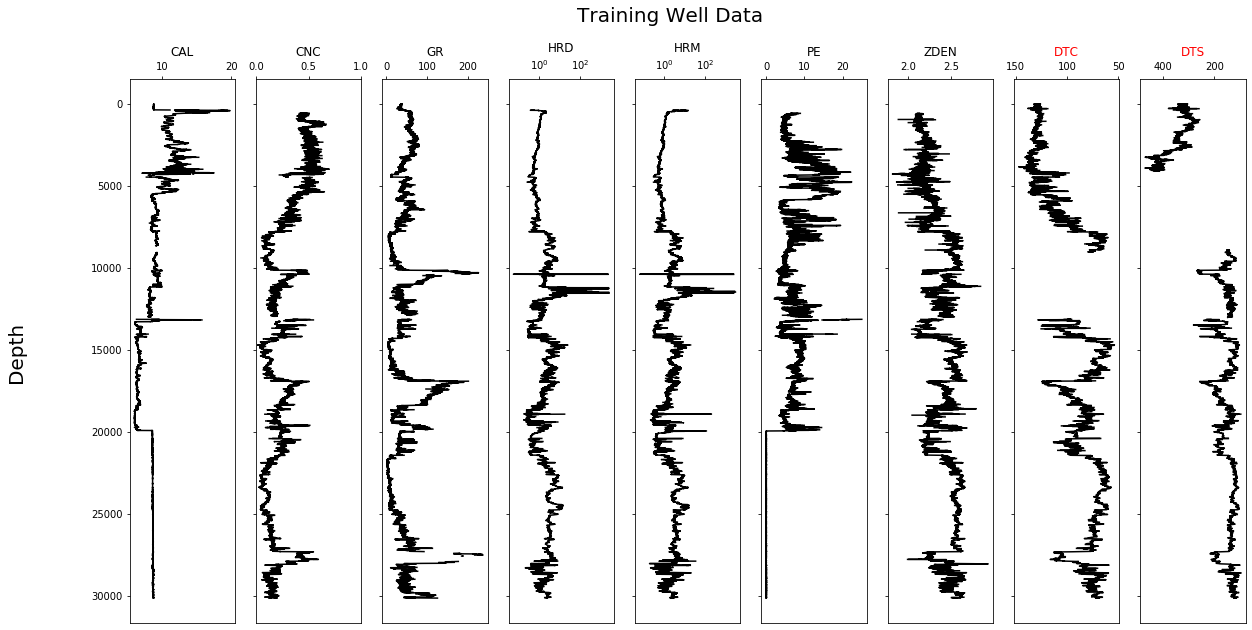

In [22]:
cleaned_fig = plot_well_curves(df_clean)
plt.show()

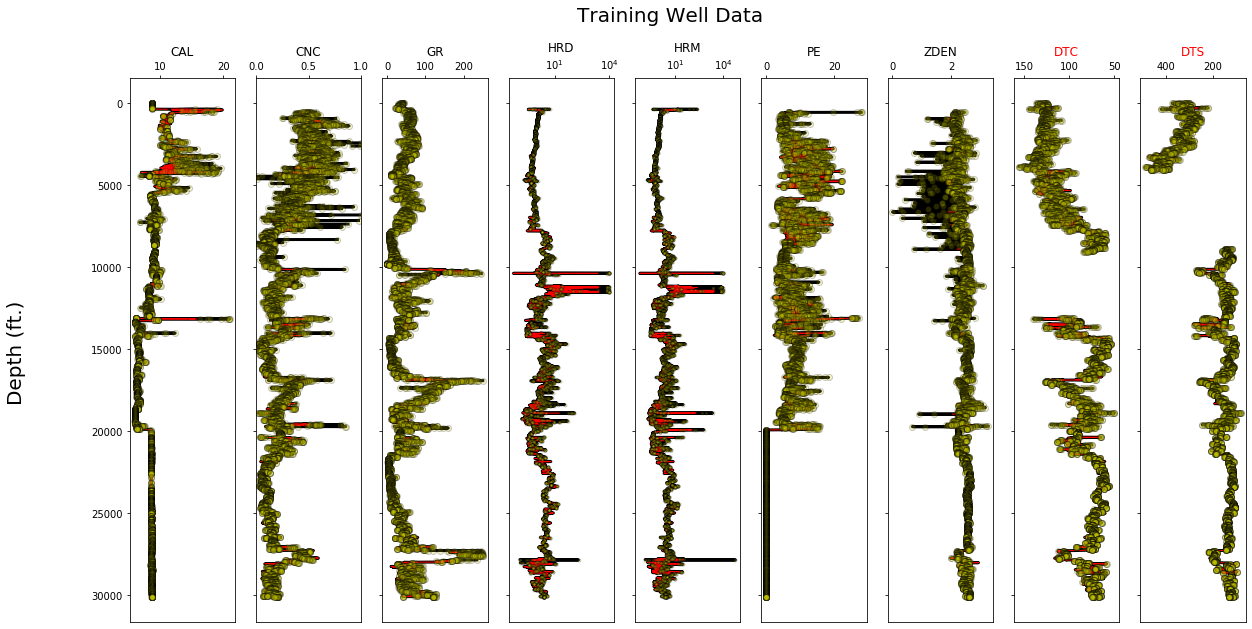

In [23]:
compare_fig = compare_well_curves(df_w1, df_clean, df_outliers)
plt.show()

In [ ]:
plt.rcParams["axes.labelsize"] = 20

In [ ]:
sns.pairplot(df_w1)
plt.show()

Upon initial inspection, it appears that there could be several outliers that may or may not be valid measurements.  They could pose a problem in establishing an accurate predictive model, so further cleaning may be required.

In [ ]:
fig = plt.figure(figsize=(12,8))
ax = sns.heatmap(df_w1.corr(), cmap="RdBu_r", annot=True, fmt=".2f")
ax.set_title('Correlation Coefficient Heatmap of Well Log Curves')
plt.show()